In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 1. Load Raw Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Load Target values

In the target-dataset, we have 1206 patients(1206 rows in the dataset) and 583 different targets(583 different target values). If we build a machine learning model, we can predict these 583 different targets. The target selection is based on us.

In [ ]:
#Load the target file to Jupyter Notebook

import pandas as pd
import numpy as np

df_struct = pd.read_csv('/content/drive/MyDrive/GUDHI-tda-tutorials-mapper/df_struct.csv')
print(df_struct.shape)

(1206, 583)


In [ ]:
#Let's see what kind of targets we have:
df_struct.columns

Index(['Unnamed: 0', 'Subject', 'Release', 'Acquisition', 'Gender', 'Age',
       '3T_Full_MR_Compl', 'T1_Count', 'T2_Count', '3T_RS-fMRI_Count',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=583)

## 1.2 Load DTI connectivity matrices of 998 patients:

Our goal is to predict targets given by connectivity matrices. These connectivity matrices represent neural relationships of different brain regions. We have 998 connectivity matrices so we have 998 patients.

In [ ]:
# Let's now load it into a list of 998 pandas DataFrames
import pickle
open_file = open('/content/drive/MyDrive/GUDHI-tda-tutorials-mapper/DTI.txt', "rb")
loaded_DTI = pickle.load(open_file)
open_file.close()

In [ ]:
#Just to check that we 998 connectivity matrixes
len(loaded_DTI), type(loaded_DTI)

(998, list)

In [ ]:
loaded_DTI[0].shape

(116, 116)

The connectivity matrices have shape (116,116). That means we have 116 brain regions.

## 1.3 Take tranpose to make matrices symmetric

Our connectivity matrices are not symmetric. The DTI_ab matrix measures the amount of fibers from a to b and DTI_ba from b to a, which may differ. Simply, we have a directed graph:

In [ ]:
DTI_sym = loaded_DTI.copy()

In [ ]:
loaded_DTI[0]

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
data.1,,,,,,,,,,,,,,,,,,,,,
Precentral_L,0.000000,0.111284,0.244940,0.036833,0.000000,0.000000,0.316256,0.031119,0.000000,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Precentral_R,0.058161,0.000000,0.024979,0.077539,0.000000,0.000000,0.003282,0.193988,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_L,0.638208,0.124529,0.000000,0.278553,0.276687,0.012743,1.000000,0.275736,0.078628,0.029371,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_R,0.077435,0.311908,0.224755,0.000000,0.014218,1.000000,0.040737,1.000000,0.024073,0.350583,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_Orb_L,0.000000,0.000000,0.031933,0.002034,0.000000,0.000000,0.002370,0.000000,0.542085,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vermis_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031301,0.237843,0.366248,0.000000,0.432853,0.124460,0.226047,1.000000
Vermis_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.043103,0.232500,0.000000,0.446245,0.076638,0.506090,0.000000,0.855930,0.774257,0.206943
Vermis_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040640,0.415833,0.000000,0.473040,0.080923,0.134490,0.791066,0.000000,0.986443,0.269161


In [ ]:
#Make the matrices symmetric

for i in range(len(loaded_DTI)):
    DTI_sym[i] = (DTI_sym[i] + DTI_sym[i].T)/2
DTI_sym[0]

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
data.1,,,,,,,,,,,,,,,,,,,,,
Precentral_L,0.000000,0.084723,0.441574,0.057134,0.000000,0.000000,0.570140,0.037480,0.000000,0.021363,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Precentral_R,0.084723,0.000000,0.074754,0.194723,0.000000,0.000000,0.009822,0.358454,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_L,0.441574,0.074754,0.000000,0.251654,0.154310,0.007062,1.000000,0.212413,0.045227,0.015506,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_R,0.057134,0.194723,0.251654,0.000000,0.008126,0.567128,0.045612,0.835060,0.014280,0.187429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Frontal_Sup_Orb_L,0.000000,0.000000,0.154310,0.008126,0.000000,0.000000,0.011454,0.000000,0.624236,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vermis_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.020406,0.178908,0.496907,0.000000,0.469472,0.129475,0.236835,0.685049
Vermis_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.029044,0.136159,0.000000,0.319384,0.094477,0.469472,0.000000,0.823498,0.749837,0.136225
Vermis_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027964,0.246444,0.000000,0.346928,0.104622,0.129475,0.823498,0.000000,0.993222,0.180674


In [ ]:
len(DTI_sym), type(DTI_sym), type(DTI_sym[0])

(998, list, pandas.core.frame.DataFrame)

## 1.4 Load IDs of 998 patient:

In the target-dataset we had 1206 patients, however we have 998 connectivity matrices. So we need to select 998 patients' target values. How to do it? By matching the IDs of patients. First we load the patient IDs:

In [ ]:
# You may need the IDs of all DTI networks in your project. We give this for you here:
#!wget -O 'IDsDTI.txt' https://www.dropbox.com/s/k7wuffrr0e26a7m/IDsDTI.txt?dl=0
open_file = open('/content/drive/MyDrive/GUDHI-tda-tutorials-mapper/IDsDTI.txt', "rb")
DTI_IDs = pickle.load(open_file)
open_file.close()

In [ ]:
len(DTI_IDs), type(DTI_IDs)

(998, list)

In [ ]:
DTI_IDs = pd.DataFrame(DTI_IDs,columns =['Subject'])
DTI_IDs.head()

,Subject
0,120212
1,108222
2,111009
3,393247
4,211821


## 1.5 Match ID's with target values:

We do mathing the patient IDs with the target values here. The 'Subject' column in both datasets represent the IDs.

In [ ]:
df_targets = df_struct.copy()

for i in range(len(df_targets)):
    flag=0
    for j in range(len(DTI_IDs)):
        if int(DTI_IDs['Subject'][j])== df_targets['Subject'][i]:
            flag = 1
    if flag==0:
        df_targets = df_targets.drop([i])

In [ ]:
df_targets.shape

(998, 583)

##1.6 Exract AGE column

In [ ]:
age_col  = df_targets["Age"].copy()
age_col_np = age_col.to_numpy()

ages=[]
#Group the age categories:
for i in range(len(age_col)):
  if age_col_np[i]== '22-25':
    ages.append(0)
  elif age_col_np[i]== '26-30':
    ages.append(1)
  elif age_col_np[i]== '31-35':
    ages.append(2)
  elif age_col_np[i]== '36+':
    ages.append(3)


#2. Create torch.geometric Data graphs (Raw)

In [ ]:
import scipy.sparse
import torch

from torch_geometric.data import Data
from torch_geometric.testing import withPackage
from torch_geometric.utils import (
    from_networkx,
    from_scipy_sparse_matrix,
    from_trimesh,
    subgraph,
    to_networkx,
    to_scipy_sparse_matrix,
    to_trimesh,
)
def test_from_networkx():
    x = torch.randn(2, 8)
    print("x = ", x)
    pos = torch.randn(2, 3)
    edge_index = torch.tensor([[0, 1, 0], [1, 0, 0]])
    edge_attr = torch.tensor([[1,3], [2,3], [3,3]])
    #edge_attr = torch.randn(edge_index.size(1))
    print(edge_attr)
    print(edge_attr.shape)
    print(type(edge_attr))
    perm = torch.tensor([0, 2, 1])
    data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)
    G = to_networkx(data, node_attrs=['x', 'pos'], edge_attrs=['edge_attr'])
    data = from_networkx(G)
    print(data)
    assert len(data) == 4
    assert data.x.tolist() == x.tolist()
    assert data.pos.tolist() == pos.tolist()
    assert data.edge_index.tolist() == edge_index[:, perm].tolist()
    assert data.edge_attr.tolist() == edge_attr[perm].tolist()

#test_from_networkx()

2.1 Visualize graphs

<ipython-input-19-5725b1989961>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_empty = df_empty.append(new_row, ignore_index=True)
<ipython-input-19-5725b1989961>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_empty = df_empty.append(new_row, ignore_index=True)
<ipython-input-19-5725b1989961>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_empty = df_empty.append(new_row, ignore_index=True)
<ipython-input-19-5725b1989961>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_empty = df_empty.append(new_row, ignore_index=True)
<ipython-input-19-5725b1989961>:14: FutureWarning: The frame.append method is deprecated and wil

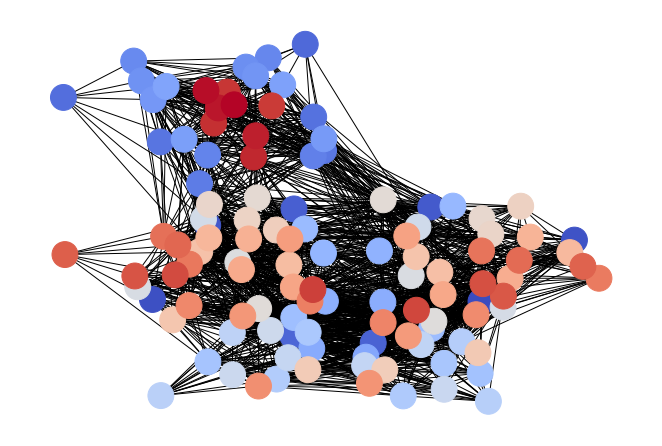

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from pylab import rcParams
import networkx as nx

df_empty = pd.DataFrame({'source': [], 'target':[], 'weight' : []})
DTI_sym_np_temp = DTI_sym[990].to_numpy()
columns = DTI_sym[990].columns

for i in range(0,116):
  for j in range(i,116):
    if DTI_sym_np_temp[i][j] != 0.:
      new_row = {'source': columns[i], 'target': columns[j], 'weight': DTI_sym_np_temp[i][j] }
      df_empty = df_empty.append(new_row, ignore_index=True)

G = nx.from_pandas_edgelist(df_empty, 'source', 'target', ["weight"])
color_lookup = {k:v for v, k in enumerate(sorted(set(G.nodes())))}
# {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'J': 6, 'K': 7, 'Z': 8}

low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 9, 6
nx.draw(G,
        nodelist=color_lookup,
        node_size=670,
        node_color=[mapper.to_rgba(i)
                    for i in color_lookup.values()],
        with_labels=0)
plt.show()

In [ ]:
def is_in(first, second, already_looked):
  if already_looked==[]:
    return 0
  else:
    for i in range(len(already_looked)):
      if already_looked[i][0] == first and already_looked[i][1] == second:
        return 1
    return 0



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
import torch
import scipy.sparse
import random
import torch
from sklearn.preprocessing import normalize

from torch_geometric.data import Data
from torch_geometric.testing import withPackage
from torch_geometric.utils import (
    from_networkx,
    from_scipy_sparse_matrix,
    from_trimesh,
    subgraph,
    to_networkx,
    to_scipy_sparse_matrix,
    to_trimesh,
)

DTI_torch_geometric_graphs=[]
for dti in range( 0,500):#len(DTI_sym)):
  print(dti)

  DTI_sym_np = DTI_sym[dti].to_numpy()
  G = nx.from_numpy_array(DTI_sym_np) #Bu CALISIYOR!!

  #edge_index'i kendi hesapliyor zaten.Önce torch.geometric grapah cevirip ordan Torch.tensor type'ında edge_index'i kaydediyoruz


  #Node attribute'ü ayarla:
  eigen = nx.eigenvector_centrality(G, weight='weight',tol=1e-03)
  #betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True)
  closeness = nx.closeness_centrality(G)


  random_number = random.randint(1, 100)

  node_attributes=[]
  for i in range(len(eigen)):

    #node_attributes.append( [ closeness[i]])     #eigen[i]#, betweenness[i], closeness[i]] )
    node_attributes.append( [ random_number * 1.0] )
  x = torch.tensor(node_attributes)


  #Edge attribute'ü ayarla
  G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
  edge_attr0=[]
  edge_indexes = [[],[]]
  for (key, value)in G_distance_dict.items():
    edge_attr0.append(value)
    #edge_attr.append([value])
    edge_indexes[0].append(key[0])
    edge_indexes[1].append(key[1])


  edge_indexes = torch.LongTensor(edge_indexes)
  edge_attr = [float(i)/sum(edge_attr0) for i in edge_attr0]

  '''
  #Edge index'i ayarla
  pyg_graph = from_networkx(G)
  #edge_index = pyg_graph.edge_index

  index =0
  already_looked=[(0,0)]
  edge_index_tmp = torch.empty((2, int(pyg_graph.edge_index.shape[1]/2)))
  for i in range( int(pyg_graph.edge_index.shape[1]) ):
    if is_in(pyg_graph.edge_index[0][i], pyg_graph.edge_index[1][i], already_looked) == 0:
      edge_index_tmp[0][index] = int(pyg_graph.edge_index[0][i])
      edge_index_tmp[1][index] = int(pyg_graph.edge_index[1][i])
      already_looked.append( (pyg_graph.edge_index[1][i], pyg_graph.edge_index[0][i]) )
      already_looked.append( (pyg_graph.edge_index[0][i], pyg_graph.edge_index[1][i]) )
      index +=1
  '''
  #Data objesini hazırla
  data = Data(x=x,  edge_index=edge_indexes, edge_attr=torch.Tensor(edge_attr), y = torch.LongTensor([ages[dti]]) )


  DTI_torch_geometric_graphs.append(data)

DTI_torch_geometric_graphs[0]

#3. Build GNN model (raw)

In [ ]:
data = DTI_torch_geometric_graphs[0]
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')

Data(x=[116, 1], edge_index=[2, 1893], edge_attr=[1893], y=[1])
Number of nodes: 116
Number of edges: 1893
Average node degree: 16.32
Has isolated nodes: False
Has self-loops: False


In [ ]:
#torch.manual_seed(12345)
#dataset = dataset.shuffle()

train_dataset = DTI_torch_geometric_graphs[:400]
test_dataset = DTI_torch_geometric_graphs[400:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#for step, data in enumerate(train_loader):
    #print(f'Step {step + 1}:')
    #print('=======')
    #print(f'Number of graphs in the current batch: {data.num_graphs}')
    #print(data)
    #print()

Number of training graphs: 400
Number of test graphs: 100


In [ ]:
#USE edge attr
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
from torch_geometric.nn import global_mean_pool


class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv_params={}):
        super(GNN, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = GCNConv(input_size, hidden_channels, **conv_params)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, **conv_params)
        self.conv3 = GCNConv(hidden_channels, hidden_channels, **conv_params)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch,  edge_col = None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
        # 2. Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GNN(input_size = 1, hidden_channels=64)

In [ ]:
'''
#NOT USE edge attr

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GCN(hidden_channels=8)
print(model)
'''

'\n#NOT USE edge attr\n\nfrom torch.nn import Linear\nimport torch.nn.functional as F\nfrom torch_geometric.nn import GCNConv, NNConv\nfrom torch_geometric.nn import global_mean_pool\n\n\nclass GCN(torch.nn.Module):\n    def __init__(self, hidden_channels):\n        super(GCN, self).__init__()\n        torch.manual_seed(12345)\n        self.conv1 = GCNConv(1, hidden_channels)\n        self.conv2 = GCNConv(hidden_channels, hidden_channels)\n        self.conv3 = GCNConv(hidden_channels, hidden_channels)\n        self.lin = Linear(hidden_channels, 4)\n\n    def forward(self, x, edge_index, batch):\n        # 1. Obtain node embeddings \n        x = self.conv1(x, edge_index)\n        x = x.relu()\n        x = self.conv2(x, edge_index)\n        x = x.relu()\n        x = self.conv3(x, edge_index)\n        # 2. Readout layer\n        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]\n        # 3. Apply a final classifier\n        x = F.dropout(x, p=0.5, training=self.training)\n 

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

#model = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    losss=0
    for data in train_loader:  # Iterate in batches over the training dataset.

         #Not use edge attr
         #out = model(data.x, data.edge_index, data.batch)
         #Use edge attr
         out = model(data.x, data.edge_index, data.batch, data.edge_attr)  # Perform a single forward pass.

         loss = criterion(out, data.y)  # Compute the loss.
         losss+=loss
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    print(losss)

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         #out = model(data.x, data.edge_index, data.batch)
         out = model(data.x, data.edge_index, data.batch, data.edge_attr)
         #print("out=",out)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #print("pred=",pred)
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
         #print("correct = ",correct)

     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print()


#4. Create Topological graphs

##4.1 cover_complex.py (helper functions)


In [ ]:
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt

from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.cluster         import DBSCAN, AgglomerativeClustering
from sklearn.metrics         import pairwise_distances
from scipy.spatial.distance  import directed_hausdorff

In [ ]:
class CoverComplexPy(BaseEstimator, TransformerMixin):
    """
    This is a mother class for MapperComplex, GraphInducedComplex and NerveComplex.
    Attributes:
        simplex_tree (gudhi SimplexTree): simplicial complex representing the cover complex computed after calling the fit() method.
        node_info (dictionary): various information associated to the nodes of the cover complex.
    """
    def __init__(self, input_name="data", cover_name="cover", color_name="color", verbose=False):
        """
        Constructor for the CoverComplexPy class.
        Parameters:
        """
        self.input_name, self.cover_name, self.color_name, self.verbose = input_name, cover_name, color_name, verbose

    def get_networkx(self, get_attrs=False):
        """
        Turn the 1-skeleton of the cover complex computed after calling fit() method into a networkx graph.
        This function requires networkx (https://networkx.org/documentation/stable/install.html).
        Parameters:
            get_attrs (bool): if True, the color functions will be used as attributes for the networkx graph.
        Returns:
            G (networkx graph): graph representing the 1-skeleton of the cover complex.
        """
        try:
            import networkx as nx
            st = self.simplex_tree
            G = nx.Graph()
            for (splx,_) in st.get_skeleton(1):
                if len(splx) == 1:
                    G.add_node(splx[0])
                if len(splx) == 2:
                    G.add_edge(splx[0], splx[1])
            if get_attrs:
                attrs = {k: {"attr_name": self.node_info[k]["colors"]} for k in G.nodes()}
                nx.set_node_attributes(G, attrs)
            return G
        except ImportError:
            print("Networkx not found, nx graph not computed")

    def print_to_dot(self, epsv=.2, epss=.4):
        """
        Write the cover complex in a DOT file called "{self.input_name}.dot", that can be processed with, e.g., neato.
        Parameters:
            epsv (float): scale the node colors between [epsv, 1-epsv]
            epss (float): scale the node sizes between [epss, 1-epss]
        """
        st = self.simplex_tree
        node_info = self.node_info

        maxv, minv = max([node_info[k]["colors"][0] for k in node_info.keys()]), min([node_info[k]["colors"][0] for k in node_info.keys()])
        maxs, mins = max([node_info[k]["size"]      for k in node_info.keys()]), min([node_info[k]["size"]      for k in node_info.keys()])

        f = open(self.input_name + ".dot", "w")
        f.write("graph MAP{")
        cols = []
        for (simplex,_) in st.get_skeleton(0):
            cnode = (1.-2*epsv) * (node_info[simplex[0]]["colors"][0] - minv)/(maxv-minv) + epsv if maxv != minv else 0
            snode = (1.-2*epss) * (node_info[simplex[0]]["size"]-mins)/(maxs-mins) + epss if maxs != mins else 1
            f.write(  str(simplex[0]) + "[shape=circle width=" + str(snode) + " fontcolor=black color=black label=\""  + "\" style=filled fillcolor=\"" + str(cnode) + ", 1, 1\"]")
            cols.append(cnode)
        for (simplex,_) in st.get_filtration():
            if len(simplex) == 2:
                f.write("  " + str(simplex[0]) + " -- " + str(simplex[1]) + " [weight=15];")
        f.write("}")
        f.close()

        L = np.linspace(epsv, 1.-epsv, 100)
        colsrgb = []
        try:
            import colorsys
            for c in L:
                colsrgb.append(colorsys.hsv_to_rgb(c,1,1))
            fig, ax = plt.subplots(figsize=(6, 1))
            fig.subplots_adjust(bottom=0.5)
            my_cmap = matplotlib.colors.ListedColormap(colsrgb, name=self.color_name)
            cb = matplotlib.colorbar.ColorbarBase(ax, cmap=my_cmap, norm=matplotlib.colors.Normalize(vmin=minv, vmax=maxv), orientation="horizontal")
            cb.set_label(self.color_name)
            fig.savefig("colorbar_" + self.color_name + ".pdf", format="pdf")
            plt.close()
        except ImportError:
            print("colorsys not found, colorbar not printed")

    def print_to_txt(self):
        """
        Write the cover complex to a TXT file called "{self.input_name}.txt", that can be processed with KeplerMapper.
        """
        st = self.simplex_tree
        f = open(self.input_name + ".txt", "w")
        f.write(self.input_name + "\n")
        f.write(self.cover_name + "\n")
        f.write(self.color_name + "\n")
        f.write("0 0\n")
        f.write(str(st.num_vertices()) + " " + str(len(list(st.get_skeleton(1)))-st.num_vertices()) + "\n")
        name2id = {}
        idv = 0
        for s,_ in st.get_skeleton(0):
            f.write(str(idv) + " " + str(self.node_info[s[0]]["colors"][0]) + " " + str(self.node_info[s[0]]["size"]) + "\n")
            name2id[s[0]] = idv
            idv += 1
        for s,_ in st.get_skeleton(1):
            if len(s) == 2:
                f.write(str(name2id[s[0]]) + " " + str(name2id[s[1]]) + "\n")
        f.close()

    class _constant_clustering():
        def fit_predict(X):
            return np.zeros([len(X)], dtype=np.int32)


class MapperComplex(CoverComplexPy, BaseEstimator, TransformerMixin):
    """
    This is a class for computing Mapper simplicial complexes on point clouds or distance matrices.
    """
    def __init__(self, input_type="point cloud", colors=None, mask=0,
                       filters=None, filter_bnds=None, resolutions=None, gains=None, clustering=DBSCAN(), N=100, beta=0., C=10.,
                       input_name="data", cover_name="cover", color_name="color", verbose=False):
        """
        Constructor for the MapperComplex class.
        Parameters:
            input_type (string): type of input data. Either "point cloud" or "distance matrix".
            colors (numpy array of shape (num_points) x (num_colors)): functions used to color the nodes of the cover complex. More specifically, coloring is done by computing the means of these functions on the subpopulations corresponding to each node. If None, first coordinate is used if input is point cloud, and eccentricity is used if input is distance matrix.
            mask (int): threshold on the size of the cover complex nodes (default 0). Any node associated to a subpopulation with less than **mask** points will be removed.
            filters (numpy array of shape (num_points) x (num_filters)): filter functions (sometimes called lenses) used to compute the cover. Each column of the numpy array defines a scalar function defined on the input points.
            filter_bnds (numpy array of shape (num_filters) x 2): limits of each filter, of the form [[f_1^min, f_1^max], ..., [f_n^min, f_n^max]]. If one of the values is numpy.nan, it can be computed from the dataset with the fit() method.
            resolutions (numpy array of shape num_filters containing integers): resolution of each filter function, ie number of intervals required to cover each filter image. If None, it is estimated from data.
            gains (numpy array of shape num_filters containing doubles in [0,1]): gain of each filter function, ie overlap percentage of the intervals covering each filter image.
            clustering (class): clustering class (default sklearn.cluster.DBSCAN()). Common clustering classes can be found in the scikit-learn library (such as AgglomerativeClustering for instance). If None, it is set to hierarchical clustering, with scale estimated from data.
            N (int): subsampling iterations (default 100) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            beta (double): exponent parameter (default 0.) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.) for estimating scale and resolutions. Used only if clustering or resolutions = None. See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            input_name (string): name of dataset. Used when generating plots.
            cover_name (string): name of cover. Used when generating plots.
            color_name (string): name of color function. Used when generating plots.
            verbose (bool): whether to display info while computing.
        """
        self.filters, self.filter_bnds, self.resolutions, self.gains, self.colors, self.clustering = filters, filter_bnds, resolutions, gains, colors, clustering
        self.input_type, self.mask, self.N, self.beta, self.C = input_type, mask, N, beta, C
        CoverComplexPy.__init__(self, input_name, cover_name, color_name, verbose)

    def estimate_scale(self, X, N=100, inp="point cloud", beta=0., C=10.):
        """
        Compute estimated scale of a point cloud or a distance matrix.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            N (int): subsampling iterations (default 100). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            inp (string): either "point cloud" or "distance matrix". Type of input data (default "point cloud").
            beta (double): exponent parameter (default 0.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
        Returns:
            delta (double): estimated scale that can be used with eg agglomerative clustering.
        """
        num_pts = X.shape[0]
        delta, m = 0., int(  num_pts / np.exp((1+beta) * np.log(np.log(num_pts)/np.log(C)))  )
        for _ in range(N):
            subpop = np.random.choice(num_pts, size=m, replace=False)
            if inp == "point cloud":
                d, _, _ = directed_hausdorff(X, X[subpop,:])
            if inp == "distance matrix":
                d = np.max(np.min(X[:,subpop], axis=1), axis=0)
            delta += d/N
        return delta

    def get_optimal_parameters_for_agglomerative_clustering(self, X, beta=0., C=10., N=100):
        """
        Compute optimal scale and resolutions for a point cloud or a distance matrix.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            beta (double): exponent parameter (default 0.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            C (double): constant parameter (default 10.). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
            N (int): subsampling iterations (default 100). See http://www.jmlr.org/papers/volume19/17-291/17-291.pdf for details.
        Returns:
            delta (double): optimal scale that can be used with agglomerative clustering.
            resolutions (numpy array of shape (num_filters): optimal resolutions associated to each filter.
        """
        num_filt, delta = self.filters.shape[1], 0
        delta = self.estimate_scale(X=X, N=N, inp=self.input_type, C=C, beta=beta)

        pairwise = pairwise_distances(X, metric="euclidean") if self.input_type == "point cloud" else X
        pairs = np.argwhere(pairwise <= delta)
        num_pairs = pairs.shape[0]
        res = []
        for f in range(num_filt):
            F = self.filters[:,f]
            resf = 0
            for p in range(num_pairs):
                resf = max(resf, abs(F[pairs[p,0]] - F[pairs[p,1]]))
            res.append(resf)

        return delta, np.array(res)

    def fit(self, X, y=None):
        """
        Fit the MapperComplex class on a point cloud or a distance matrix: compute the Mapper complex and store it in a simplex tree called simplex_tree.
        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) if point cloud and (num_points) x (num_points) if distance matrix): input point cloud or distance matrix.
            y (n x 1 array): point labels (unused).
        """
        if self.filters is None:
            if self.input_type == "point cloud":
                self.filters = X[:,0:1]
            elif self.input_type == "distance matrix":
                self.filters = X.max(axis=0)[:,None]
        if self.colors is None:
            if self.input_type == "point cloud":
                self.colors = X[:,0:1]
            elif self.input_type == "distance matrix":
                self.colors = X.max(axis=0)[:,None]

        num_pts, num_filters = self.filters.shape[0], self.filters.shape[1]

        # If some filter limits are unspecified, automatically compute them
        if self.filter_bnds is None:
            self.filter_bnds = np.hstack([np.min(self.filters, axis=0)[:,np.newaxis], np.max(self.filters, axis=0)[:,np.newaxis]])

        # If some resolutions are not specified, automatically compute them
        if self.gains is None:
            self.gains = .33 * np.ones(num_filters)
        if self.resolutions is None or self.clustering is None:
            delta, resolutions = self.get_optimal_parameters_for_agglomerative_clustering(X=X, beta=self.beta, C=self.C, N=self.N)
            if self.clustering is None:
                if self.input_type == "point cloud":
                    self.clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta, affinity="euclidean")
                else:
                    self.clustering = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta, affinity="precomputed")
            if self.resolutions is None:
                self.resolutions = np.multiply(resolutions, 1./self.gains)
                self.resolutions = np.array([int( (self.filter_bnds[ir,1]-self.filter_bnds[ir,0])/r) for ir, r in enumerate(self.resolutions)])

        # Initialize attributes
        self.simplex_tree, self.node_info = SimplexTree(), {}

        if np.all(self.gains < .5):

            # Compute which points fall in which patch or patch intersections
            interval_inds, intersec_inds = np.empty(self.filters.shape), np.empty(self.filters.shape)
            for i in range(num_filters):
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                intersec_endpoints = []
                for j in range(1, len(interval_endpoints)-1):
                    intersec_endpoints.append(interval_endpoints[j] - g*l / (2 - 2*g))
                    intersec_endpoints.append(interval_endpoints[j] + g*l / (2 - 2*g))
                interval_inds[:,i] = np.digitize(f, interval_endpoints)
                intersec_inds[:,i] = 0.5 * (np.digitize(f, intersec_endpoints) + 1)

            # Build the binned_data map that takes a patch or a patch intersection and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    a, b = interval_inds[i,j], intersec_inds[i,j]
                    list_preimage.append([a])
                    if b == a:
                        list_preimage[j].append(a+1)
                    if b == a-1:
                        list_preimage[j].append(a-1)
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        else:

            # Compute interval endpoints for each filter
            l_int, r_int = [], []
            for i in range(num_filters):
                L, R = [], []
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                for j in range(len(interval_endpoints)-1):
                    L.append(interval_endpoints[j]   - g*l / (2 - 2*g))
                    R.append(interval_endpoints[j+1] + g*l / (2 - 2*g))
                l_int.append(L)
                r_int.append(R)

            # Build the binned_data map that takes a patch or a patch intersection and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    fval = self.filters[i,j]
                    start, end = int(min(np.argwhere(np.array(r_int[j]) >= fval))), int(max(np.argwhere(np.array(l_int[j]) <= fval)))
                    list_preimage.append(list(range(start, end+1)))
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        # Initialize the cover map, that takes a point and outputs the clusters to which it belongs
        cover, clus_base = [[] for _ in range(num_pts)], 0

        # For each patch
        for preimage in binned_data:

            # Apply clustering on the corresponding subpopulation
            idxs = np.array(binned_data[preimage])
            if len(idxs) > 1:
                clusters = self.clustering.fit_predict(X[idxs,:]) if self.input_type == "point cloud" else self.clustering.fit_predict(X[idxs,:][:,idxs])
            elif len(idxs) == 1:
                clusters = np.array([0])
            else:
                continue

            # Collect various information on each cluster
            num_clus_pre = np.max(clusters) + 1
            for clus_i in range(num_clus_pre):
                node_name = clus_base + clus_i
                subpopulation = idxs[clusters == clus_i]
                self.node_info[node_name] = {}
                self.node_info[node_name]["indices"] = subpopulation
                self.node_info[node_name]["size"] = len(subpopulation)
                self.node_info[node_name]["colors"] = np.mean(self.colors[subpopulation,:], axis=0)
                self.node_info[node_name]["patch"] = preimage

            # Update the cover map
            for pt in range(clusters.shape[0]):
                node_name = clus_base + clusters[pt]
                if clusters[pt] != -1 and self.node_info[node_name]["size"] >= self.mask:
                    cover[idxs[pt]].append(node_name)

            clus_base += np.max(clusters) + 1

        # Insert the simplices of the Mapper complex
        for i in range(num_pts):
            self.simplex_tree.insert(cover[i])

        return self


In [ ]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 27.1 MB/s eta 0:00:00


In [ ]:
#from gudhi.sklearn import MapperComplex, GraphInducedComplex, NerveComplex
#from cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
#Instead of above, we define the MapperComplex in a cell in this notebook above

from gudhi import bottleneck_distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [ ]:
from scipy.sparse.csgraph    import dijkstra, shortest_path, connected_components
from scipy.stats             import ks_2samp, entropy, ttest_ind

def find(i, parents):
    if parents[i] == i:
        return i
    else:
        return find(parents[i], parents)

def union(i, j, parents, f):
    if f[i] <= f[j]:
        parents[j] = i
    else:
        parents[i] = j

def compute_topological_features(M, threshold=0.):
    """
    Compute the topological features (connected components, up/down branches, loops) of
    the 1-skeleton of the cover complex. Connected components and loops are computed with scipy
    functions, and branches are detected with Union-Find and 0-dimensional persistence of the 1-skeleton.
    Parameters:
        threshold (float): any topological feature whose size is less than this parameter
        (relative to the first color function) will be discarded.
    Returns:
        dgm (list of (dim,(a,b)) tuples): list of feature characteristics. dim is the
        topological dimension of the feature (0 for CCs and branches, 1 for loops), a,b are the min and max
        of the first color function along the feature.
        bnds (list of lists): list of feature points. Each element of this list is the list of point IDs
        forming the corresponding feature.
    """
    st = M.simplex_tree
    num_nodes = st.num_vertices()
    function, namefunc, invnamefunc = {}, {}, {}
    nodeID = 0
    for (s,_) in st.get_skeleton(0):
        namefunc[s[0]] = nodeID
        invnamefunc[nodeID] = s[0]
        function[s[0]] = M.node_info[s[0]]["colors"][0]
        nodeID += 1
    dgm, bnd = [], []

    # connected_components
    A = np.zeros([num_nodes, num_nodes])
    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            A[namefunc[splx[0]], namefunc[splx[1]]] = 1
            A[namefunc[splx[1]], namefunc[splx[0]]] = 1
    _, ccs = connected_components(A, directed=False)
    for ccID in np.unique(ccs):
        pts = np.argwhere(ccs == ccID).flatten()
        vals = [function[invnamefunc[p]] for p in pts]
        if np.abs(min(vals) - max(vals)) >= threshold:
            dgm.append((0, (min(vals), max(vals))))
            bnd.append([invnamefunc[p] for p in pts])

    # loops
    G = M.get_networkx()
    try:
        from networkx import cycle_basis
        bndall = cycle_basis(G)
        for pts in bndall:
            vals = [function[p] for p in pts]
            if np.abs(min(vals) - max(vals)) >= threshold:
                dgm.append((1,(min(vals), max(vals))))
                bnd.append(pts)
    except ImportError:
        print("Networkx not found, loops not computed")

    # branches
    for topo_type in ["downbranch", "upbranch"]:

        lfunction = []
        for i in range(num_nodes):
            lfunction.append(function[invnamefunc[i]])

        # upranch is downbranch of opposite function
        if topo_type == "upbranch":
            lfunction = [-f for f in lfunction]

        # sort vertices according to function values and compute inverse function
        sorted_idxs = np.argsort(np.array(lfunction))
        inv_sorted_idxs = np.zeros(num_nodes)
        for i in range(num_nodes):
            inv_sorted_idxs[sorted_idxs[i]] = i

        # go through all vertices in ascending function order
        persistence_diag, persistence_set, parents, visited = {}, {}, -np.ones(num_nodes, dtype=np.int32), {}
        for i in range(num_nodes):

            current_pt = sorted_idxs[i]
            neighbors = np.ravel(np.argwhere(A[current_pt,:] == 1))
            lower_neighbors = [n for n in neighbors if inv_sorted_idxs[n] <= i] if len(neighbors) > 0 else []

            # no lower neighbors: current point is a local minimum
            if lower_neighbors == []:
                parents[current_pt] = current_pt

            # some lower neighbors exist
            else:

                # find parent pg of lower neighbors with lowest function value
                neigh_parents = [find(n, parents) for n in lower_neighbors]
                pg = neigh_parents[np.argmin([lfunction[n] for n in neigh_parents])]

                # set parent of current point to pg
                parents[current_pt] = pg

                # for each lower neighbor, we will create a persistence diagram point and corresponding set of nodes
                for neighbor in lower_neighbors:

                    # get parent pn
                    pn = find(neighbor, parents)
                    val = lfunction[pn]
                    persistence_set[pn] = []

                    # we will create persistence set only if parent pn is not local minimum pg
                    if pn != pg:
                        # go through all strictly lower nodes with parent pn
                        for v in sorted_idxs[:i]:
                            if find(v, parents) == pn:
                                # if it is already part of another persistence set, continue
                                try:
                                    visited[v]
                                # else, mark visited and include it in current persistence set
                                except KeyError:
                                    visited[v] = True
                                    persistence_set[pn].append(v)

                        # add current point to persistence set
                        persistence_set[pn].append(current_pt)

                        # do union and create persistence point corresponding to persistence set if persistence is sufficiently large
                        if np.abs(lfunction[pn]-lfunction[current_pt]) >= threshold:
                            persistence_diag[pn] = current_pt
                            union(pg, pn, parents, lfunction)

        for key, val in iter(persistence_diag.items()):
            if topo_type == "downbranch":
                dgm.append((0, (lfunction[key],  lfunction[val])))
            elif topo_type == "upbranch":
                dgm.append((0, (-lfunction[val], -lfunction[key])))
            bnd.append([invnamefunc[v] for v in persistence_set[key]])

    bnd = [list(b) for b in bnd]
    M.persistence_diagram, M.persistence_sets = dgm, bnd
    return dgm, bnd

def bootstrap_topological_features(M, N):
    """
    Use bootstrap to empirically assess stability of the features. This function computes a distribution of
    bottleneck distances, that can used afterwards to run tests on each topological feature.
    Parameters:
        N (int): number of bootstrap iterations.
    """

    dgm = M.persistence_diagram
    num_pts, distribution = len(M.data), []
    for bootstrap_id in range(N):

        print(str(bootstrap_id) + "th iteration")

        # Randomly select points
        idxs = np.random.choice(num_pts, size=num_pts, replace=True)
        Xboot = M.data[idxs,:] if M.input_type == "point cloud" else M.data[idxs,:][:,idxs]
        f_boot, c_boot = M.filters[idxs,:], M.colors[idxs,:]
        Mboot = M.__class__(filters=f_boot, filter_bnds=M.filter_bnds, colors=c_boot,
                            resolutions=M.resolutions, gains=M.gains,
                            input_type=M.input_type, clustering=M.clustering).fit(Xboot)

        # Compute the corresponding persistence diagrams
        dgm_boot, _ = compute_topological_features(Mboot)

        # Compute the bottleneck distance
        npts, npts_boot = len(dgm), len(dgm_boot)
        D1 = np.array([[dgm[pt][1][0], dgm[pt][1][1]] for pt in range(npts)])
        D2 = np.array([[dgm_boot[pt][1][0], dgm_boot[pt][1][1]] for pt in range(npts_boot)])
        bottle = bottleneck_distance(D1, D2)
        distribution.append(bottle)
        M.distribution = np.sort(distribution)

def get_distance_from_confidence_level(M, alpha=.95, complex_type='mapper'):
    """
    Compute the bottleneck distance threshold corresponding to a specific confidence level.
    Parameters:
        alpha (float): confidence level.
    Returns:
        distance value (float); each feature whose size is above this distance is sure at confidence level alpha.
    """
    return M.distribution[int(alpha*len(M.distribution))]

def get_confidence_level_from_distance(M, distance):
    """
    Compute the confidence level of a specific bottleneck distance threshold.
    Parameters:
        distance (float): bottleneck distance threshold.
    Returns:
        confidence level (float); each feature whose size is above the distance threshold is sure at
        this confidence level.
    """
    return len(np.argwhere(M.distribution <= distance))/len(M.distribution)

def get_pvalue(M):
    """
    Compute the p-value, i.e. the opposite of the confidence level of the largest bottleneck distance
    preserving the topological features.
    Returns:
        p-value (float)
    """
    distancemin = min([np.abs(pt[1][0]-pt[1][1]) for pt in M.persistence_diagram])
    return 1.-M.compute_confidence_from_distance(distancemin)

def compute_differential_coordinates(M, nodes=None, features=None, sparse=False):
    """
    Compute the coordinates that best explain a set of nodes VS the rest of the nodes
    (in the 1-skeleton of the cover complex) with a Kolmogorov-Smirnov test.
    Only works if input_type is "point cloud".
    Parameters:
        nodes (list of integers): list of nodes to try. For instance, one can take the list of
        nodes obtained after calling "compute_topological_features"
        features (list of integers): the coordinates to try. All coordinates are tested if None.
        sparse (bool): set to True if your data is sparse and there will be speedup, otherwise use False.
    Returns:
        features (list of integers): the list of coordinates, ranked from smallest to largest p-values.
        p-values (list of float): the corresponding p-values.
    """
    if M.input_type == "distance matrix":
        print("Need coordinates for running differential coordinates!")
        raise
    #coordinates_and_pvalues = compute_differential_coordinates(cover_complex, nodes=bnd_temp[i])

    node_info = M.node_info
    X = M.data
    nodes = [s[0] for s,_ in self.simplex_tree.get_skeleton(0)] if nodes is None else nodes

    if features is None:
        features = np.arange(X.shape[1])

    #The data points create this communities
    list_idxs1 = list(np.unique(np.concatenate([node_info[node_name]["indices"] for node_name in nodes])))

    #Other data points that do not create this community
    list_idxs2 = list(set(np.arange(X.shape[0]))-set(list_idxs1))

    pvals = []
    ttvals = []
    tpvals = []
    for f in features:
        if sparse:
            Xsp = csr_matrix(X)
            group1 = np.squeeze(np.array(Xsp[list_idxs1,f].todense()))
            group2 = np.squeeze(np.array(Xsp[list_idxs2,f].todense()))
        else:
            group1, group2 = X[list_idxs1,f], X[list_idxs2,f]

        _,pval = ks_2samp(group1, group2)

        #ttval = ttest_ind(group1, group2)[0]
        #tpval = ttest_ind(group1, group2)[1]

        pvals.append(pval)

        #tpvals.append(tpval)
        #ttvals.append(ttval)

    pvals = np.array(pvals)

    #tpvals= np.array(tpvals)
    #ttvals= np.array(ttvals)

    F_ks, P_ks = features[np.argsort(pvals)], np.sort(pvals)
    #F_ent, P_ent = features[np.argsort(entvals)], np.sort(entvals)
    return F_ks, P_ks #, np.argsort(ttvals), np.sort(ttvals)

##4.2 Define filters for Mapper

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN, AgglomerativeClustering
%matplotlib notebook
%matplotlib inline
import networkx as nx
from gudhi import SimplexTree, CoverComplex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
import torch
import scipy.sparse
import torch
from sklearn.preprocessing import normalize

from torch_geometric.data import Data
from torch_geometric.testing import withPackage
from torch_geometric.utils import (
    from_networkx,
    from_scipy_sparse_matrix,
    from_trimesh,
    subgraph,
    to_networkx,
    to_scipy_sparse_matrix,
    to_trimesh,
)




Topological_torch_geometric_graphs=[]


for dti in range( 0,15):#len(DTI_sym)):
  print(dti)

  DTI_sym_np = DTI_sym[dti].to_numpy()

  #Calculate L-Infinity filter:
  pairwise_dist = squareform(pdist(DTI_sym_np, 'euclidean'))
  L_infinity = np.amax(pairwise_dist, axis = 1)
  #print(L_infinity.shape)

  svd = TruncatedSVD(n_components=1, n_iter=7, random_state=42)
  SVD_filter = svd.fit_transform(DTI_sym_np)
  #print(SVD_filter.shape)

  filters= np.concatenate((L_infinity[:,np.newaxis], SVD_filter ), axis=1)

  #DEFINE MAPPER for each graph instance
  cover_complex = MapperComplex(
    input_type='distance matrix',
    colors = filters,
    mask=0,

    #clustering = None,
    clustering=DBSCAN(eps = 0.5, min_samples=5, metric ="cosine"),
    #clustering = AgglomerativeClustering(n_clusters=None, linkage="complete",
                                         #distance_threshold=0.5, affinity="cosine"),

    N=100, beta=0., C=10,

    #LENS:
    filters = filters,

    filter_bnds=None,

    #resolutions = Number of intervals required to cover each filter image
    #When you increase this, num of communities increase
    resolutions = np.array([13, 13]), # When you decrease this, num of data points decrease. 90

    #gains = Overlap percentage of the intervals covering each filter image.
    gains=np.array([0.5, 0.5]),  #When you decrease this, data-points lose connections 0.91
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)
  #MAPPER COMPLEX COMPUTATION
  _ = cover_complex.fit(DTI_sym_np)
  G = cover_complex.get_networkx()


  #Node attribute'ü ayarla:
  eigen = nx.eigenvector_centrality(G, weight='weight',tol=1e-03)
  #betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True)
  #closeness = nx.closeness_centrality(G)
  node_attributes=[]
  for i in range(len(eigen)):
    node_attributes.append( [ eigen[i]] ) #, betweenness[i], closeness[i]] )
  x = torch.tensor(node_attributes)




  #Edge index'i ayarla
  pyg_graph = from_networkx(G)
  #edge_index = pyg_graph.edge_index

  index =0
  already_looked=[(0,0)]
  edge_index_tmp = torch.empty((2, int(pyg_graph.edge_index.shape[1]/2)))
  for i in range( int(pyg_graph.edge_index.shape[1]) ):
    if is_in(pyg_graph.edge_index[0][i], pyg_graph.edge_index[1][i], already_looked) == 0:
      edge_index_tmp[0][index] = int(pyg_graph.edge_index[0][i])
      edge_index_tmp[1][index] = int(pyg_graph.edge_index[1][i])
      already_looked.append( (pyg_graph.edge_index[1][i], pyg_graph.edge_index[0][i]) )
      already_looked.append( (pyg_graph.edge_index[0][i], pyg_graph.edge_index[1][i]) )
      index +=1
  print("edge_index = ",edge_index_tmp)
  print(len(edge_index_tmp), len(edge_index_tmp[0]))


  bb = nx.edge_betweenness_centrality(G, normalized=False)
  print(bb)
  nx.set_edge_attributes(G, bb, "betweenness")

  #Edge attribute'ü ayarla

  edge_attr0=[]
  for (key, value)in bb.items():
    edge_attr0.append(value)
    #edge_attr0.append([value])




  print()
  print(edge_attr0)
  print()
  #edge_attr = [float(i)/sum(edge_attr0) for i in edge_attr0]



  #Data objesini hazırla
  data = Data(x=x,  edge_index=edge_index_tmp.long(), edge_attr=torch.Tensor(edge_attr0), y = torch.LongTensor([ages[dti]]) )


  Topological_torch_geometric_graphs.append(data)

Topological_torch_geometric_graphs[0]

0
edge_index =  tensor([[ 0.,  0.,  1.,  6.,  8.,  8.,  9., 12., 14., 14., 14., 14., 14., 15.,
         15., 16., 16., 17., 18., 20., 22., 22., 23., 25., 27., 27., 28., 30.,
         33., 35.],
        [ 1.,  2.,  2.,  7.,  9., 10., 10., 13., 15., 16., 17., 18., 19., 18.,
         19., 17., 18., 18., 19., 21., 23., 24., 24., 26., 28., 29., 29., 31.,
         34., 36.]])
2 30
{(0, 1): 1.0, (0, 3): 1.0, (1, 3): 1.0, (6, 7): 1.0, (8, 9): 1.0, (8, 10): 1.0, (9, 10): 1.0, (12, 13): 1.0, (14, 15): 2.0, (14, 18): 2.0, (14, 19): 2.0, (14, 35): 1.0, (14, 36): 2.0, (15, 35): 2.0, (15, 36): 1.0, (18, 19): 1.0, (18, 35): 2.0, (19, 35): 2.0, (35, 36): 2.0, (16, 17): 1.0, (20, 21): 1.0, (20, 22): 1.0, (21, 22): 1.0, (23, 24): 1.0, (25, 26): 1.0, (25, 27): 1.0, (26, 27): 1.0, (28, 29): 1.0, (31, 32): 1.0, (33, 34): 1.0}

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

1
edge_index =  tensor([[ 0., 

Data(x=[37, 1], edge_index=[2, 30], edge_attr=[30], y=[1])

In [ ]:
Topological_torch_geometric_graphs[0]

Data(x=[37, 1], edge_index=[2, 30], edge_attr=[30], y=[1])

In [ ]:
Topological_torch_geometric_graphs[0]


Data(x=[37, 1], edge_index=[2, 30], edge_attr=[30], y=[1])

In [ ]:
DTI_torch_geometric_graphs[0]

Data(x=[116, 1], edge_index=[2, 1893], edge_attr=[1893], y=[1])

#5. GNN model (raw + topological graphs)

In [ ]:
train_dataset = DTI_torch_geometric_graphs + Topological_torch_geometric_graphs[:8]
test_dataset = Topological_torch_geometric_graphs[8:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Number of training graphs: 508
Number of test graphs: 7
Step 1:
Number of graphs in the current batch: 16
DataBatch(x=[1856, 1], edge_index=[2, 28483], edge_attr=[28483], y=[16], batch=[1856], ptr=[17])

Step 2:
Number of graphs in the current batch: 16
DataBatch(x=[1776, 1], edge_index=[2, 25407], edge_attr=[25407], y=[16], batch=[1776], ptr=[17])

Step 3:
Number of graphs in the current batch: 16
DataBatch(x=[1783, 1], edge_index=[2, 26500], edge_attr=[26500], y=[16], batch=[1783], ptr=[17])

Step 4:
Number of graphs in the current batch: 16
DataBatch(x=[1856, 1], edge_index=[2, 27654], edge_attr=[27654], y=[16], batch=[1856], ptr=[17])

Step 5:
Number of graphs in the current batch: 16
DataBatch(x=[1856, 1], edge_index=[2, 27134], edge_attr=[27134], y=[16], batch=[1856], ptr=[17])

Step 6:
Number of graphs in the current batch: 16
DataBatch(x=[1768, 1], edge_index=[2, 25993], edge_attr=[25993], y=[16], batch=[1768], ptr=[17])

Step 7:
Number of graphs in the current batch: 16
DataBa

In [ ]:
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
from torch_geometric.nn import global_mean_pool


class GNN2(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = conv(
            input_size, hidden_channels, **conv_params)
        self.conv2 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch,  edge_col = None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)

        # 2. Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]


        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN2(input_size = 1, hidden_channels=64, conv = GCNConv)
print(model)

GNN2(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
import sklearn.metrics as metrics

def train(train_loader, model, optimizer, criterion, edge_col_name):
    model.train()

    losses = []
    #print("edge_col_name = ",edge_col_name)
    for data in train_loader:  # Iterate in batches over the training dataset.
        #print(data)
        if edge_col_name==None:
            out = model(data.x, data.edge_index, data.batch)
        else:
            #print(data)
            out = model(data.x, data.edge_index, data.batch, data.edge_attr)

        loss = criterion(out, data.y.long())  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        losses.append(loss.cpu().detach().numpy())

    return np.mean(losses)

def test(loader, model,  edge_col_name, metric = metrics.accuracy_score):

    model.eval()

    score = 0
    for data in loader:
        if edge_col_name==None:
            out = model(data.x, data.edge_index, data.batch)
        else:
            out = model(data.x, data.edge_index, data.batch, data[edge_col_name])

        y_pred = out.argmax(dim=1).detach().numpy()
        y_true = data.y.long().cpu().detach().numpy()

        score += metric(y_true, y_pred)

    return score/len(loader)

def train_test(
    train_loader, test_loader, model, model_params,   edge_col_name=None,
    learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500):


    model = model(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    k=0

    loss, train_score, test_score = [], [], []

    for epoch in range(n_epochs):
        loss += [train(train_loader, model,  optimizer, criterion, edge_col_name)]
        train_score += [test(train_loader, model, edge_col_name)]
        test_score += [test(test_loader, model, edge_col_name)]

        if (epoch+1)%10==0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss[-1]:.4f}, Train: {train_score[-1]:.4f}, Test: {test_score[-1]:.4f}')

        results = pd.DataFrame({
            'loss': loss,
            'train_score': train_score, 'test_score': test_score,
            #'time':(time.time()-t0)/60
        })

        # enable early stopping
        if (epoch > 1) and abs(loss[-1]/loss[-2]-1) < min_acc :
            k += 1
        if k> e_patience:
            print('Early stopping, epoch', epoch)
            break

    return model, results



In [ ]:
N_EPOCHS = 500
E_PATIENCE = 50
LEARNING_RATE = 0.01

In [ ]:
N = 3

In [ ]:
def train_test_CV(train_dataset, test_dataset, GNN, model_params,
                  edge_col_name = None,
                  learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500, N=4):

    for i in range(N):
        print("CROSS VALIDATION - ", i+1)

        #train_dataset, test_dataset = split_dataset(dataset_target, Y)

        train_loader = DataLoader(train_dataset, batch_size=16)
        test_loader = DataLoader(test_dataset, batch_size=16)
        #print("geldi0")
        for data in train_loader:
          #print(data)

          model, results = train_test(
              train_loader, test_loader,
              GNN, model_params,   edge_col_name,
              learning_rate, e_patience, n_epochs = n_epochs)

          results_df = results.iloc[-1:] if i == 0 else pd.concat([results_df, results.iloc[-1:]])

          #print(results_df)

    means = pd.DataFrame(results_df.mean()).T.rename(columns={c:c+'_mean' for c in results_df.columns})
    stds = pd.DataFrame(results_df.std()).T.rename(columns={c:c+'_std' for c in results_df.columns})
    results_df = pd.concat([means, stds], axis=1).reset_index(drop=True)

    return model, results_df

IndentationError: ignored

In [ ]:
# using edge_weight for GCN

model_params = {"input_size":1, "hidden_channels":64, 'conv':GCNConv}

model, results = train_test_CV(
    train_dataset, test_dataset, GNN2, model_params,
      edge_col_name='edge_attr',
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

results['model'] = 'GCNConv'
results['nb_layers'] = 3
results['edge_weight'] = True
#results_df['edge_weight'] = False

#results_df = pd.concat([results_df, results], axis=0)

In [ ]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x, data.edge_index, batch=None)
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y.long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

